## Version 03 -> Pred RUL

In [1]:
!pip install texttable
from platform import python_version
print(python_version())

3.8.5


In [2]:
# importing required libraries
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint as pp
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pprint import pprint
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, ARDRegression, SGDRegressor
from texttable import Texttable
import math
from sklearn.metrics import r2_score

# getting the battery data
# bs_all = [
#     'B0005', 'B0006', 'B0007', 'B0018', 'B0025', 'B0026', 'B0027', 'B0028', 'B0029', 'B0030', 'B0031', 'B0032', 
#     'B0042', 'B0043', 'B0044', 'B0045', 'B0046', 
#     'B0047', 'B0048'
# ]
bs_all = [
    'B0005', 'B0006', 'B0007', 'B0018'
]
ds = {}
for b in bs_all:
    ds[b] = loadmat(f'DATA/{b}.mat')
    
types = {}
times = {}
ambient_temperatures = {}
datas = {}

for b in bs_all:
    x = ds[b][b]["cycle"][0][0][0]
    ambient_temperatures[b] = x['ambient_temperature']
    types[b] = x['type']
    times[b] = x['time']
    datas[b] = x['data']

# clubbing all the compatible batteries together
# Batteries are compatible if they were recorded under similar conditions
# And their data size match up
bs_compt = {}

for b in bs_all:
    sz = 0
    for j in range(datas[b].size):
        if types[b][j] == 'discharge':
            sz += 1
    if bs_compt.get(sz):
        bs_compt[sz].append(b)
    else: 
        bs_compt[sz] = [ b ]
pp(bs_compt)
BSSS = bs_compt

{132: ['B0018'], 168: ['B0005', 'B0006', 'B0007']}


In [3]:
## CRITICAL TIME POINTS FOR A CYCLE
## We will only these critical points for furthur training

## TEMPERATURE_MEASURED
## => Time at highest temperature

## VOLTAGE_MEASURED
## => Time at lowest Voltage

## VOLTAGE_LOAD
## => First time it drops below 1 volt after 1500 time

def getTemperatureMeasuredCritical(tm, time):
    high = 0
    critical = 0
    for i in range(len(tm)):
        if (tm[i] > high):
            high = tm[i]
            critical = time[i]
    return critical

def getVoltageMeasuredCritical(vm, time):
    low = 1e9
    critical = 0
    for i in range(len(vm)):
        if (vm[i] < low):
            low = vm[i]
            critical = time[i]
    return critical

def getVoltageLoadCritical(vl, time):
    for i in range(len(vl)):
        if (time[i] > 1500 and vl[i] < 1):
            return time[i]
    return -1

## MODEL
* Considering 1 Cycle for RUL estimation

## Features
* [CP1, CP2, CP3, Capacity] -> RUL

## Remaining Useful Life
* n = number of cycles above threshold
* RUL of Battery after (cycle x) = (1 - (x / n)) * 100

In [4]:
## X: Features
## y: RUL
## x: no. of cycles to merge
def merge(X, y, x):
    XX = []
    yy = []
    
    sz = len(X)
    for i in range(sz - x + 1):
        curr = []
        for j in range(x):
            for a in X[i + j]:
                curr.append(a)
        XX.append(curr)
#         val = 0
#         for j in range(x):
#             val += y[i + j]
#         val /= x
        yy.append(y[i + x - 1])
        
    return XX, yy

In [5]:
## Data Structure
    # Cycles[battery][param][cycle]
    # Cycles[battery][Capacity][cycle]

Cycles = {}
params = ['Temperature_measured', 'Voltage_measured', 'Voltage_load', 'Time']

rmses = []

for bs_cmpt in bs_compt:
    rmses.append([])

# iterate over the merge hyper parameter
for xx in range(1, 10):

    results = Texttable()
    results.add_row(['Compatible Batteries', 'Cycles', 'MAE', 'RMSE', 'R2 Score' ])
    
    loc = 0
    
    # iterate over all the battery sets
    for bs_cmpt in bs_compt:
        # getting data for a given set

        # y contains RUL after current cycle
        # model will train for y
        y = []

        bs = bs_compt[bs_cmpt]
        for b in bs:
            Cycles[b] = {}
            for param in params:
                Cycles[b][param] = []
                for j in range(datas[b].size):
                    if types[b][j] == 'discharge':
                        Cycles[b][param].append(datas[b][j][param][0][0][0])

            cap = []
            for j in range(datas[b].size):
                if types[b][j] == 'discharge':
                    cap.append(datas[b][j]['Capacity'][0][0][0][0])
            Cycles[b]['Capacity'] = np.array(cap)
            Cycles[b]['count'] = len(Cycles[b][params[0]])

            effective_cycle_count = 0
            for x in Cycles[b]['Capacity']:
                if (x < 1.4):
                    break
                effective_cycle_count += 1

            for i in range(len(Cycles[b]['Capacity'])):
                if (i < effective_cycle_count):
                    y.append((1 - ((i + 1) / effective_cycle_count)) * 100)
                else:
                    y.append(0)

        # preparing data for regression model
        temperature_measured = []
        voltage_measured = []
        voltage_load = []
        capacity = []

        for b in bs:        
            for c in Cycles[b]['Capacity']:
                capacity.append(c)
            for i in range(Cycles[b]['count']):
                temperature_measured.append(getTemperatureMeasuredCritical(Cycles[b]['Temperature_measured'][i], Cycles[b]['Time'][i]))
                voltage_measured.append(getVoltageMeasuredCritical(Cycles[b]['Voltage_measured'][i], Cycles[b]['Time'][i]))
                voltage_load.append(getVoltageLoadCritical(Cycles[b]['Voltage_load'][i], Cycles[b]['Time'][i]))

        # creating the model
        X = []
        for i in range(len(temperature_measured)):
            X.append(np.array([temperature_measured[i], voltage_measured[i], voltage_load[i], capacity[i]]))
    #     X.append(np.array(capacity))
        X = np.array(X)
        y = np.array(y)
        
        # merge cycles
        X, y = merge(X, y, xx)

        # creating train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

        # fitting the model
        regressor = LinearRegression()
        regressor.fit(X_train, y_train)

        # test
        y_pred = regressor.predict(X_test)

        # model evaluation
        diff = 0
        total = 0
        rmse = 0
        for i in range(len(y_test)):
            diff += abs(y_test[i] - y_pred[i])
            rmse += ((y_test[i] - y_pred[i]) * (y_test[i] - y_pred[i]))
            total += y_test[i]
        diff /= len(y_test)
        total /= len(y_test)
        rmse = math.sqrt(rmse / len(y_test))
    #     accuracy = ((total - diff) / total) * 100
        accuracy = r2_score(y_test, y_pred)

        # Adding evaluation to result array to print in a table
        results.add_row([ str(bs), str(Cycles[bs[0]]['count']), diff, rmse, accuracy ])
        
        rmses[loc].append(rmse)
        loc += 1

    # printing results
#     print(f'Evaluation: Clubbing Compatible Batteries for cycle param: {xx}\n{results.draw()}')

In [6]:
# print(rmses)

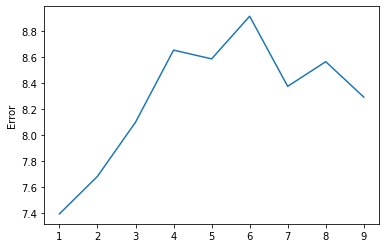

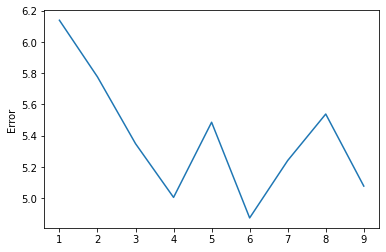

In [7]:
for rm in rmses:
    plt.plot(range(1, len(rm) + 1), rm)
    plt.ylabel("Error")
    plt.show()

In [8]:
def removeFromGroup(x):
    loc = 0
    y = {}
    for a in x:
        for b in x[a]:
            y[loc] = [ b ]
            loc += 1
    return y

In [9]:
!pip install scikit-elm

In [11]:
## Data Structure
    # Cycles[battery][param][cycle]
    # Cycles[battery][Capacity][cycle]

from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm    
    
Cycles = {}
params = ['Temperature_measured', 'Voltage_measured', 'Voltage_load', 'Time']

# remove batteries from group
bs_compt = BSSS
bs_compt = removeFromGroup(bs_compt)


depths_test = []
depths_train = []

for bs_cmpt in bs_compt:
    depths_test.append([bs_compt[bs_cmpt][0]])
    depths_train.append([bs_compt[bs_cmpt][0]])
    
# iterate over the depths
for depth in tqdm(range(3, 21)):

    rmses = []
    rmses_train = []

    for bs_cmpt in bs_compt:
        rmses.append([bs_compt[bs_cmpt][0]])
        rmses_train.append([bs_compt[bs_cmpt][0]])

    
    # iterate over the merge hyper parameter
    for xx in range(1, 41):

        results = Texttable()
        results.add_row([ 'Compatible Batteries', 'Cycles', 'MAE', 'RMSE', 'R2 Score' ])

        loc = 0

        # iterate over all the battery sets
        for bs_cmpt in bs_compt:
            # getting data for a given set

            # y contains RUL after current cycle
            # model will train for y
            y = []

            bs = bs_compt[bs_cmpt]
            for b in bs:
                Cycles[b] = {}
                for param in params:
                    Cycles[b][param] = []
                    for j in range(datas[b].size):
                        if types[b][j] == 'discharge':
                            Cycles[b][param].append(datas[b][j][param][0][0][0])

                cap = []
                for j in range(datas[b].size):
                    if types[b][j] == 'discharge':
                        cap.append(datas[b][j]['Capacity'][0][0][0][0])
                Cycles[b]['Capacity'] = np.array(cap)
                Cycles[b]['count'] = len(Cycles[b][params[0]])

                effective_cycle_count = 0
                for x in Cycles[b]['Capacity']:
                    if (x < 1.4):
                        break
                    effective_cycle_count += 1

                for i in range(len(Cycles[b]['Capacity'])):
                    if (i < effective_cycle_count):
                        y.append((1 - ((i + 1) / effective_cycle_count)) * 100)
                    else:
                        y.append(0)

            # preparing data for regression model
            temperature_measured = []
            voltage_measured = []
            voltage_load = []
            capacity = []

            for b in bs:        
                for c in Cycles[b]['Capacity']:
                    capacity.append(c)
                for i in range(Cycles[b]['count']):
                    temperature_measured.append(getTemperatureMeasuredCritical(Cycles[b]['Temperature_measured'][i], Cycles[b]['Time'][i]))
                    voltage_measured.append(getVoltageMeasuredCritical(Cycles[b]['Voltage_measured'][i], Cycles[b]['Time'][i]))
                    voltage_load.append(getVoltageLoadCritical(Cycles[b]['Voltage_load'][i], Cycles[b]['Time'][i]))

            # creating the model
            X = []
            for i in range(len(temperature_measured)):
                X.append(np.array([temperature_measured[i], voltage_measured[i], voltage_load[i], capacity[i]]))
        #     X.append(np.array(capacity))
            X = np.array(X)
            y = np.array(y)

            # merge cycles
            X, y = merge(X, y, xx)

            # creating train test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

            ############## ------------------ MODEL ------------------- ####################

            ### Random Forest Regressor ### (BEST)
            regressor = RandomForestRegressor(max_depth = depth, random_state= 0)
            regressor.fit(X_train, y_train)
            y_pred = regressor.predict(X_test)
            y_pred_train = regressor.predict(X_train)

            ############# ----------------- MODEL -------------------- #####################

            # model evaluation
            diff = 0
            total = 0
            rmse = 0
            for i in range(len(y_test)):
                diff += abs(y_test[i] - y_pred[i])
                rmse += ((y_test[i] - y_pred[i]) * (y_test[i] - y_pred[i]))
                total += y_test[i]
            diff /= len(y_test)
            total /= len(y_test)
            rmse = math.sqrt(rmse / len(y_test))
            accuracy2 = ((total - diff) / total) * 100
            accuracy = r2_score(y_test, y_pred)

            # Adding evaluation to result array to print in a table
    #         results.add_row([ str(bs), str(Cycles[bs[0]]['count']), diff, rmse, accuracy, accuracy2 ])

            rmses[loc].append(rmse)

            #### adding rmses of the train
            rmse_train = 0
            for i in range(len(y_train)):
                rmse_train += ((y_train[i] - y_pred_train[i]) * (y_train[i] - y_pred_train[i]))
            rmse_train = math.sqrt(rmse_train / len(y_train))
            rmses_train[loc].append(rmse_train)
            loc += 1

        # printing results
    #     print(f'Evaluation: Clubbing Compatible Batteries for cycle param: {xx}\n{results.draw()}')
    
    ## setting errors for depths
    for i in range(len(rmses)):
        
        rm = rmses[i]
        rm_train = rmses_train[i]

        mn = 100000
        mn_train = 100000
        loc, loc_train = -1, -1
        for j in range(1, len(rm)):
            if (mn > rm[j]):
                mn = rm[j]
                loc = j

            if (mn_train > rm_train[j]):
                mn_train = rm_train[j]
                loc_train = j
        
        depths_test[i].append(mn)
        depths_train[i].append(mn_train)

100%|██████████| 18/18 [14:10<00:00, 47.22s/it]


In [12]:
%matplotlib
for i in range(len(depths_test)):
    rm = depths_test[i]
    rm_train = depths_train[i]
    
    mn = 100000
    mn_train = 100000
    loc, loc_train = -1, -1
    for i in range(1, len(rm)):
        if (mn > rm[i]):
            mn = rm[i]
            loc = i
        
        if (mn_train > rm_train[i]):
            mn_train = rm_train[i]
            loc_train = i
            
    print(f"Minima Test: {mn}, Depth: {loc}")
    print(f"Minima Train: {mn_train}, Depth: {loc_train}")
    
    fig, ax = plt.subplots()
    ax.plot(range(3, len(rm) + 2), rm[1:])
    ax.plot(range(3, len(rm) + 2), rm_train[1:])
    plt.ylabel(rm[0])
    plt.xlabel("Random Forest Regressor Max-Depth (Hyper-param)")
    plt.show()

Using matplotlib backend: Qt5Agg
Minima Test: 0.45944155427729894, Depth: 6
Minima Train: 0.26002986467389244, Depth: 4
Minima Test: 0.6711554317677308, Depth: 4
Minima Train: 0.4127800071535105, Depth: 3
Minima Test: 0.29760281341004335, Depth: 6
Minima Train: 0.24190013292878176, Depth: 6
Minima Test: 0.5913611058246204, Depth: 3
Minima Train: 0.3407219138897158, Depth: 5
